# Notebook n°1: Détection de la profondeur
### Sources :
###     - article : Alhashim, I., & Wonka, P. (2018). High Quality Monocular Depth Estimation via Transfer Learning. ArXiv E-Prints, abs/1812.11941. Retrieved from https://arxiv.org/abs/1812.11941
###     - code : Ialhashim, I. (2022, 9 novembre). GitHub - ialhashim/DenseDepth : High Quality Monocular Depth Estimation via Transfer Learning. GitHub. https://github.com/ialhashim/DenseDepth

## 1) Importation des librairies

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from model import DepthEstimate

import os
from io import BytesIO
from zipfile import ZipFile

import tensorflow as tf
import pandas as pd
import numpy as np

from sklearn.utils import shuffle

In [ ]:
with ZipFile('drive/MyDrive/NYUV2_dataset.zip', 'r') as zipObj:
  zipObj.extractall()

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## 2) Hyperparamètres

In [ ]:
batch_size     = 8
learning_rate  = 0.00001 #learning_rate  = 0.0001
epochs         = 10
val_split      = 0.2

## 3) Définition du modèle

In [ ]:
model = DepthEstimate(backbone="densenet121", freeze=False)

29084464/29084464 [==============================] - 2s 0us/step
Base model loaded DenseNet121

Model created.


In [ ]:
model.build(input_shape=(None, None, None, 3))
model.summary()

Model: "depth_estimate"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Encoder)           multiple                  7037504   
                                                                 
 decoder (Decoder)           multiple                  3668705   
                                                                 
Total params: 10,706,209
Trainable params: 10,622,561
Non-trainable params: 83,648
_________________________________________________________________


In [ ]:
model.layers[0].summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, None, None, 1024)  7037504   
                                                                 
 model (Functional)          [(None, None, None, 1024  7037504   
                             ),                                  
                              (None, None, None, 64),            
                              (None, None, None, 128)            
                             , (None, None, None, 256            
                             ),                                  
                              (None, None, None, 64)]            
                                                                 
Total params: 7,037,504
Trainable params: 6,953,856
Non-trainable params: 83,648
_________________________________________________________________


In [ ]:
model.layers[1].summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2 (Conv2D)              multiple                  524800    
                                                                 
 upscale_block (UpscaleBlock  multiple                 2359808   
 )                                                               
                                                                 
 upscale_block_1 (UpscaleBlo  multiple                 590080    
 ck)                                                             
                                                                 
 upscale_block_2 (UpscaleBlo  multiple                 147584    
 ck)                                                             
                                                                 
 upscale_block_3 (UpscaleBlo  multiple                 46144     
 ck)                                                       

## 4) Générateur de données

In [ ]:
from data import DataLoader

train_path = 'NYUV2_dataset/nyu2_train_v2.csv'

dl = DataLoader(train_path)
train_generator, val_generator = dl.get_split(batch_size, val_split)

print('Data loader ready.')

Data loader ready.


# 5) Compilation du modèle et entraînement

In [ ]:
import tensorflow
from loss import depth_loss_function

optimizer = tensorflow.keras.optimizers.Adam(learning_rate=learning_rate, amsgrad=True)

model.compile(loss=depth_loss_function, optimizer=optimizer, metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [ ]:
# Create checkpoint callback

modelLogger = tf.keras.callbacks.CSVLogger(
    filename="./drive/MyDrive/monocular-depth/model_history_log.csv", 
    append=True
)

In [ ]:
model.load_weights("./drive/MyDrive/monocular-depth/weights_epoch_9.h5")

In [ ]:
# Train model

for ep in range(10, epochs+1):

  weightsCallback = tf.keras.callbacks.ModelCheckpoint(
    filepath=f"./drive/MyDrive/monocular-depth/weights_epoch_{ep}.h5",
    save_weights_only=True
  )
  
  print("--------------- Epoch " + str(ep) + " ---------------")

  history = model.fit(
    train_generator, 
    epochs=1, 
    steps_per_epoch=int((1-val_split)*dl.length)//batch_size+1, 
    callbacks=[weightsCallback, modelLogger], 
    validation_data=val_generator, 
    validation_steps=int(val_split*dl.length)//batch_size+1
  )
  

--------------- Epoch 10 ---------------
5069/5069 [==============================] - 3846s 753ms/step - loss: 0.0688 - root_mean_squared_error: 0.2844 - val_loss: 0.0696 - val_root_mean_squared_error: 0.3211


In [ ]:
history = pd.read_csv("./drive/MyDrive/monocular-depth/model_history_log.csv")

In [ ]:
history['loss']

0    0.145584
1    0.105716
2    0.094407
3    0.087998
4    0.089535
5    0.083971
6    0.080098
7    0.077663
8    0.075446
9    0.068798
Name: loss, dtype: float64

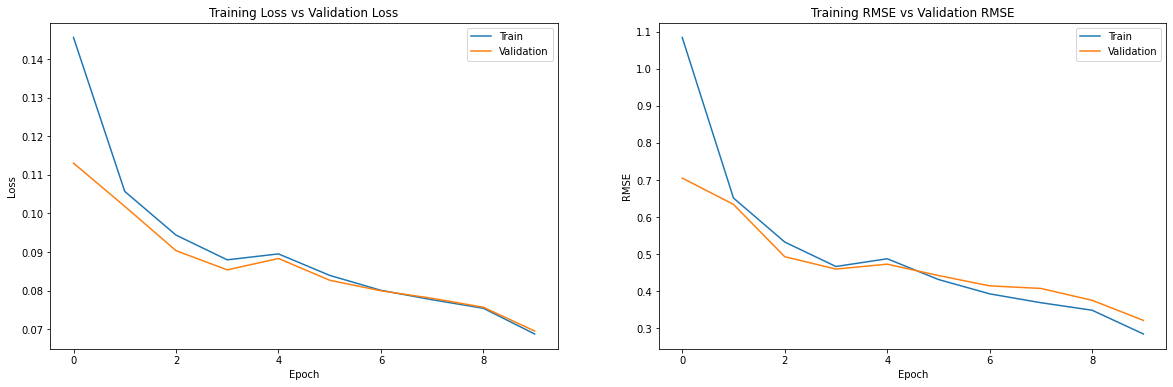

In [ ]:
import matplotlib.pyplot as plt

fig , ax = plt.subplots(1,2)
fig.set_size_inches(20, 6)

ax[0].plot(history['loss'])
ax[0].plot(history['val_loss'])
ax[0].set_title('Training Loss vs Validation Loss')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper right')

ax[1].plot(history['root_mean_squared_error'])
ax[1].plot(history['val_root_mean_squared_error'])
ax[1].set_title('Training RMSE vs Validation RMSE')
ax[1].set_ylabel('RMSE')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper right')

plt.show()

## 7) Résultats sur le jeu de test

In [ ]:
test_path = 'NYUV2_dataset/nyu2_test_v2.csv'

dl = DataLoader(test_path)
test_generator = dl.get_set(batch_size)

print('Data loader ready.')

Data loader ready.


In [ ]:
test_batch = test_generator.take(1)

imgs = []
depths = []

for img, depth in test_batch:
    imgs.append(img)
    depths.append(depth)

In [ ]:
# model loading
"""
from layers import BilinearUpSampling2D

custom_model = tf.keras.models.load_model("./training/best.h5", custom_objects={"BilinearUpSampling2D": BilinearUpSampling2D})

print('Models weights loaded.')
"""

'\nfrom layers import BilinearUpSampling2D\n\ncustom_model = tf.keras.models.load_model("./training/best.h5", custom_objects={"BilinearUpSampling2D": BilinearUpSampling2D})\n\nprint(\'Models weights loaded.\')\n'

In [ ]:
outputs = model.predict(imgs) * 255

1/1 [==============================] - 0s 54ms/step


In [ ]:
fig , axes = plt.subplots(batch_size, 3)
fig.set_size_inches(10, 20)

for ax in axes.ravel():
    ax.axis("off")
    
for i in range(batch_size):
    if i==0:
        axes[i, 0].set_title("RGB image")
        axes[i, 1].set_title("GT")
        axes[i, 2].set_title("My Model")
        
    axes[i, 0].imshow(imgs[0][i])
    axes[i, 1].imshow(np.reshape(depths[0][i], (240, 320)), cmap="plasma")
    axes[i, 2].imshow(np.reshape(outputs[i], (240, 320)), cmap="plasma")